In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host='localhost',user='root',password='9651',database='ecommerce');
cur = db.cursor()


In [5]:
query = 'select customer_id from orders'
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data ,columns=["order_id"])
df.head()

,order_id
0,9ef432eb6251297304e76186b10a928d
1,b0830fb4747a6c6d20dea0b8c802d7ef
2,41ce2a54c0b03bf3443c3d931a367089
3,f88197465ea7920adcdbec7375364d82
4,8ab97904e6daea8866dbdbc4fb7aad2c


In [10]:
#Calculate the moving average of order values for each customer over their order history.
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id 
order by order_purchase_timestamp 
rows between 2 preceding and current row) as mov_avg
 from 
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders 
on payments.order_id = orders.order_id) as a;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer_id","order_purchase_timestamp","payment","mov_avg"])
df.head()

,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998


In [19]:
# Q2. Calculate the cumulate sales per month for each year.

query = """ select years,months,payment,sum(payment) over (order by years, months)as cumulative_sales
from
(select year(orders.order_purchase_timestamp) as years,
monthname(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id =  payments.order_id group by years,months order by years,months) as a

"""

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data, columns= ["years","Months","payment","Cumulative Sales"])
df.head()


,years,Months,payment,Cumulative Sales
0,2016,December,235.44,235.44
1,2016,October,709085.76,709321.20
2,2016,September,3026.88,712348.08
3,2017,April,5013456.35,5725804.43
4,2017,August,8092755.84,13818560.27


In [4]:
#Q3. Calculate the year-over-year growth rate of total sales.
query = """with a as(select year(orders.order_purchase_timestamp) as  years ,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id group by years order by years)

select years,((payment-lag(payment,1) over(order by years))/lag(payment,1) over(order by years))*100 from a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["years","yoy Growth%"])
df

,years,yoy Growth%
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


In [11]:
#Q4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 
# months of their first purchase. 

query = """with a as(select customers.customer_id, min(orders.order_purchase_timestamp) as first_order from customers join orders 
on customers.customer_id = orders.customer_id group by customer_id),

b as(select a.customer_id, count(distinct orders.order_purchase_timestamp)as next_order from a join orders 
on a.customer_id = orders.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp< date_add(first_order, interval 6 month) group by customer_id)

select 100 *(count(distinct a.customer_id)/count(distinct b.customer_id)) from a left join b
on a.customer_id = b.customer_id
"""

cur.execute(query)
data = cur.fetchall()
df  = pd.DataFrame(data,columns = ["customer_id"])

df



,customer_id
0,None


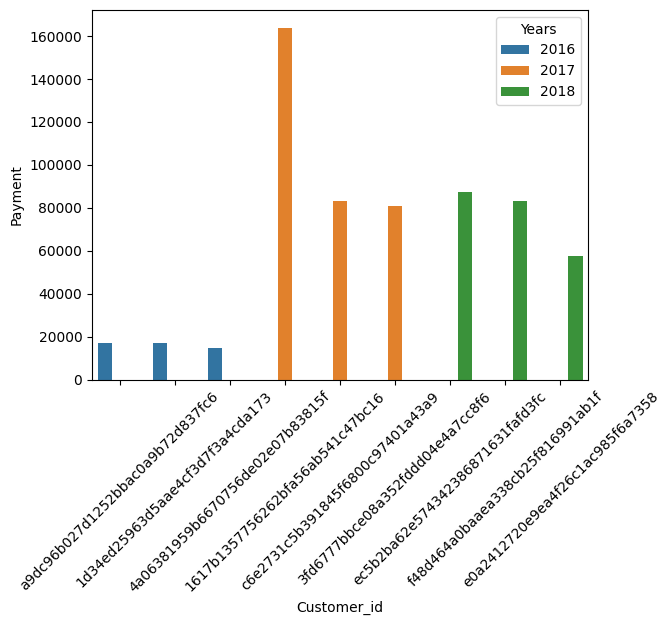

In [28]:
#Q5. identify the top 3 customers who spent the most money in each year.

query = """ select years,customer_id,payment,Ranks
from
(select year(orders.order_purchase_timestamp) as years,orders.customer_id, sum(payments.payment_value) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value)desc ) as Ranks
 from orders join payments on orders.order_id = payments.order_id 
 group by  year(orders.order_purchase_timestamp), orders.customer_id) as a
 where Ranks <= 3
"""

cur.execute(query)
data = cur.fetchall()
df =pd.DataFrame(data,columns = ["Years","Customer_id","Payment","Ranks"])

df.head()
sns.barplot(x ="Customer_id", y ="Payment", data = df,hue = "Years")
plt.xticks(rotation  = 45)
plt.show()

